# Replication Project: Soil Property Maps of Africa

**Replication Game – Berlin, 30 October 2025 Berlin**  

---

**Institut for Replication & Freie Universität Berlin**  

**Author:** [Dominik Bursy](mailto:dominik.bursy@icloud.com)  

**Last Updated:** October 2025

---

**Reference:**  
Berazneva, Julia, and Tanya S. Byker. 2017. *Does Forest Loss Increase Human Disease? Evidence from Nigeria.* American Economic Review, 107(5), 516–521. https://doi.org/10.1257/aer.p20171132

---

**Resources:**  
- [Guidelines on the Use of DHS GPS Data (English)](https://dhsprogram.com/publications/publication-SAR8-Spatial-Analysis-Reports.cfm)
- [Africa SoilGrids - Soil organic carbon (SOC)](https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/9a66a37e-8a4e-463b-b83a-fd49049c323a)
- [Africa SoilGrids - Soil pH in H2O](https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/a3364e47-9229-4a6d-aed2-487fd7e4dccc)
- [Africa SoilGrids - Cation exchange capacity (CEC)](https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/e0d921ff-5f7b-48e5-ae27-7c1515055e3b)


**Notes:**  
- EPSG:3857 is a spherical Mercator projected coordinate system in meters, ideal for web mapping applications like Google Maps, while EPSG:4326 is a geographic coordinate system in degrees using the WGS84 ellipsoid, which represents Earth as a 3D sphere and is used by GPS systems.
- To protect the confidentiality of respondents the geo-located data is displaced (Burgert et al., 2013). The displacement process moves the latitude and longitude to a new location under set parameters. Urban locations are displaced 0-2 kilometers while rural locations are displaced 0-5 kilometers with 1% (or every 100th point) displaced 0-10 kilometers.
- If you have trouble downloading the datasets through your browser, it’s recommended to use wget instead. This method ensures a smoother and more reliable transfer.

## Import Packages <a class="anchor" id="packages"></a>

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import rasterio
from rasterio.mask import mask

In [2]:
## Set Root Directory
ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

/Users/dominikbursy/Documents/8_PhD_New/replication_game


---

## Import Data 

In [9]:
## Import DHS Dataframe being the base structure
gdf_dhs = gpd.read_file(f"{ROOT_FOLDER}/output/gdf_dhs.geojson")

In [10]:
## Create buffer as describe in Geolinking 

# Assume gdf is your GeoDataFrame in EPSG:4326
gdf_dhs = gdf_dhs.to_crs(epsg=3857)       # Web Mercator (units = meters)

# Buffer 5000 meters (5 km) for rural and Buffer 2000 meters (2 km) for urban areas 
gdf_dhs.loc[gdf_dhs["rural"] == 1, "geometry"] = gdf_dhs.loc[gdf_dhs["rural"] == 1].buffer(5000)
gdf_dhs.loc[gdf_dhs["rural"] == 0, "geometry"] = gdf_dhs.loc[gdf_dhs["rural"] == 0].buffer(2000)

# Buffer 5000 meters (5 km) for all areas
# gdf_dhs["geometry"] = gdf_dhs.buffer(5000)

# (Optional) convert back to WGS84
gdf_dhs = gdf_dhs.to_crs(epsg=4326)

## Soil Properties

In [ ]:
def extract_raster_stats(gdf, raster_path, column_name, stat="mean", ignore_val=-9999):
    """
    Mask raster with polygons and compute statistics per polygon.
    
    Parameters
    ----------
    gdf : GeoDataFrame
        Input GeoDataFrame with polygons.
    raster_path : str
        Path to raster file (.tif).
    column_name : str
        Name of the column where results will be stored.
    stat : str, optional
        Statistic to compute ("mean", "sum", "min", "max", "median").
    ignore_val : int or float, optional
        Raster value to ignore (treated as NaN), default = -9999.
    
    Returns
    -------
    GeoDataFrame
        Original GeoDataFrame with new column containing raster stats.
    """
    with rasterio.open(raster_path) as src:
        # Reproject polygons if CRS differs
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        values = []
        for _, row in gdf.iterrows():
            geom = [row.geometry.__geo_interface__]
            try:
                out_image, _ = mask(src, geom, crop=True, all_touched=True)
                masked_array = out_image[0]

                # Replace NoData and ignore_val with NaN
                masked_array = np.where(masked_array == src.nodata, np.nan, masked_array)
                if ignore_val is not None:
                    masked_array = np.where(masked_array == ignore_val, np.nan, masked_array)

                # Keep only finite values
                valid = masked_array[np.isfinite(masked_array)]

                if valid.size == 0:
                    val = np.nan
                else:
                    if stat == "mean":
                        val = np.mean(valid)
                    elif stat == "sum":
                        val = np.sum(valid)
                    elif stat == "min":
                        val = np.min(valid)
                    elif stat == "max":
                        val = np.max(valid)
                    elif stat == "median":
                        val = np.median(valid)
                    else:
                        raise ValueError(f"Unsupported stat: {stat}")

            except ValueError:
                val = np.nan  # Polygon outside raster

            values.append(val)

    # Add results to GeoDataFrame
    gdf[column_name] = values
    return gdf


## Depth 0-5 cm

In [12]:
raster_path = f"{ROOT_FOLDER}/datasets/soil/af_ORCDRC_T__M_sd1_250m.tif"

gdf_dhs = extract_raster_stats(
    gdf=gdf_dhs,
    raster_path=raster_path,
    column_name="soil_ORCDRC",
    stat="mean",
    ignore_val=-9999
)

In [13]:
raster_path = f"{ROOT_FOLDER}/datasets/soil/af_PHIHOX_T__M_sd1_250m.tif"

gdf_dhs = extract_raster_stats(
    gdf=gdf_dhs,
    raster_path=raster_path,
    column_name="soil_PHIHOX",
    stat="mean",
    ignore_val=-9999
)

In [14]:
raster_path = f"{ROOT_FOLDER}/datasets/soil/af_CEC_T__M_sd1_250m.tif"

gdf_dhs = extract_raster_stats(
    gdf=gdf_dhs,
    raster_path=raster_path,
    column_name="soil_CEC",
    stat="mean",
    ignore_val=-9999
)

## Depth 5-15 cm

In [15]:
raster_path = f"{ROOT_FOLDER}/datasets/soil/af_ORCDRC_T__M_sd2_250m.tif"

gdf_dhs = extract_raster_stats(
    gdf=gdf_dhs,
    raster_path=raster_path,
    column_name="soil_2_ORCDRC",
    stat="mean",
    ignore_val=-9999
)

In [16]:
raster_path = f"{ROOT_FOLDER}/datasets/soil/af_PHIHOX_T__M_sd2_250m.tif"

gdf_dhs = extract_raster_stats(
    gdf=gdf_dhs,
    raster_path=raster_path,
    column_name="soil_2_PHIHOX",
    stat="mean",
    ignore_val=-9999
)

In [17]:
raster_path = f"{ROOT_FOLDER}/datasets/soil/af_CEC_T__M_sd2_250m.tif"

gdf_dhs = extract_raster_stats(
    gdf=gdf_dhs,
    raster_path=raster_path,
    column_name="soil_2_CEC",
    stat="mean",
    ignore_val=-9999
)

## Combine Soil Depth 0-5 cm and 5-15 cm

In [18]:
gdf_dhs = gdf_dhs.to_crs(4326)

In [19]:
gdf_dhs[[
    "caseid", "soil_ORCDRC", "soil_PHIHOX", "soil_CEC"
]].describe()

,soil_ORCDRC,soil_PHIHOX,soil_CEC
count,93621.000000,93621.000000,93621.000000
mean,14.053458,60.192130,10.943475
std,8.594508,3.742279,4.721043
min,3.878924,48.396657,4.270505
25%,7.288288,57.875580,7.998433
50%,10.764660,60.406467,9.478070
75%,19.885965,63.004545,11.990833
max,55.276667,74.708267,39.774747


In [20]:
gdf_dhs[[
    "caseid", "soil_2_ORCDRC", "soil_2_PHIHOX", "soil_2_CEC"
]].describe()

,soil_2_ORCDRC,soil_2_PHIHOX,soil_2_CEC
count,93621.000000,93621.000000,93621.000000
mean,10.934429,59.825361,9.676966
std,6.690138,3.931493,3.918274
min,3.094170,47.631459,4.082969
25%,5.915427,57.316397,7.362832
50%,8.577280,59.866071,8.469013
75%,15.008658,62.785377,10.445415
max,53.004444,75.304452,40.079646


In [21]:
## Combine soil depths 
gdf_dhs[ "soil_ORCDRC"] = gdf_dhs[["soil_ORCDRC", "soil_2_ORCDRC"]].mean(axis=1)
gdf_dhs[ "soil_PHIHOX"] = gdf_dhs[["soil_PHIHOX", "soil_2_PHIHOX"]].mean(axis=1)
gdf_dhs[ "soil_CEC"] = gdf_dhs[["soil_CEC", "soil_2_CEC"]].mean(axis=1)

## Export Dataframe

In [22]:
gdf_dhs[[
    "caseid", "soil_ORCDRC", "soil_PHIHOX", "soil_CEC"
]].to_csv(f"{ROOT_FOLDER}/output/dataframe_soil_depth_0_15.csv")

---

## Plot data

In [23]:
gdf_nigeria = gpd.read_file(f"{ROOT_FOLDER}/datasets/map_africa/nga_admbnda_adm2_osgof_20190417.shp")

gdf_nigeria = gdf_nigeria.reset_index(names="LGA")

gdf_nigeria = gdf_nigeria.sjoin(gdf_dhs, how="left")

In [30]:
gdf_nigeria["soil_ORCDRC_cluster_mean"] = (
    gdf_nigeria.groupby(gdf_nigeria.index)["soil_ORCDRC"]
    .transform("mean")
)

gdf_nigeria = gdf_nigeria.drop_duplicates("LGA")

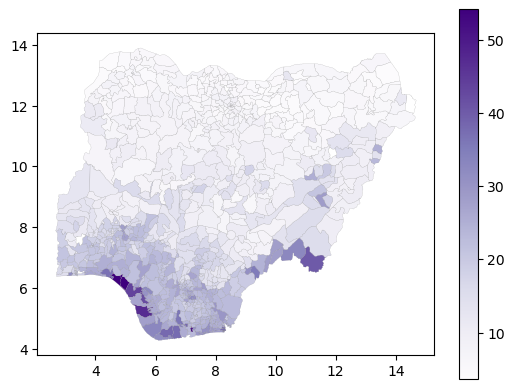

In [31]:
gdf_nigeria.plot(column="soil_ORCDRC_cluster_mean", legend=True, cmap="Purples", edgecolor="grey", linewidth=0.1, missing_kwds={
        "color": "white",
        #"edgecolor": "red",
        #"hatch": "///",
        #"label": "Missing values",
    });

---